# Shifting of Price Forwad Curves (PFCs) for Energy Markets

Toy model for the spot price for electricity:
$$
S(t) = S_0 + 
    \begin{cases}
    0 & ,0 \leq h(t) < 8\\
    P_p & ,8 \leq h(t) < 11\\
    -P_{pv} & ,11\leq h(t) < 16\\
    P_p & ,16 \leq h(t) \leq 20\\
    0 & ,20 < h(t) \leq 23
    \end{cases} +
    \begin{cases}
        0 & ,1\leq d(d) \leq 5\\
        -P_{we} & ,6\leq d(t) \leq 7
    \end{cases} +
    \begin{cases}
        0 & ,m(t) \in \{4,5,6,7,8,9\}\\
        P_{W} & ,m(t) \in \{1,2,3,10,11,12\}
    \end{cases} + \varepsilon
$$
The parameters here are:
$$
\begin{align*}
S_0 &\quad\text{Spot price level}\\
P_p & \quad\text{Peak price level}\\
P_{pv} & \quad\text{Price level with regard to solar power}\\
P_{we} & \quad\text{Price level for weekends}\\
P_W & \quad\text{Price level for winter}\\
h(t) & \quad\text{Hour of the time step $t$}\\
d(t) & \quad\text{Week day of the time step $t$}\\
m(t) & \quad\text{Month of the time step $t$}\\
\varepsilon&  \sim \mathcal{N}(\mu, \sigma^2)
\end{align*}
$$

In [30]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from rivapy.instruments.energy_futures_specifications import EnergyFutureSpecifications
from rivapy.tools.scheduler import SimpleSchedule
from rivapy.marketdata.pfc_shifter import PFCShifter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
np.random.seed(42)
def spot_price_model(timestamp: dt.datetime, spot_price_level: float, peak_price_level:float, solar_price_level: float,
                     weekend_price_level:float, winter_price_level: float, epsilon_mean: float = 0, epsilon_var:float = 1):
                    spot_price = spot_price_level
                    if (timestamp.hour >= 8 and timestamp.hour < 11) or (timestamp.hour >= 16 and timestamp.hour <= 20):
                            spot_price += peak_price_level
                    elif timestamp.hour >= 11 and timestamp.hour < 16:
                            spot_price -= solar_price_level
                    
                    if timestamp.weekday() >= 5:
                            spot_price -= weekend_price_level

                    if timestamp.month in {1,2,3,10,11,12}:
                            spot_price += winter_price_level 

                    spot_price += np.random.normal(loc=epsilon_mean, scale=np.sqrt(epsilon_var))
                    return spot_price

In [32]:
parameter_dict = {
    'spot_price_level': 100,
    'peak_price_level': 10,
    'solar_price_level': 8,
    'weekend_price_level': 10,
    'winter_price_level': 20,
    'epsilon_mean': 0,
    'epsilon_var': 5
}


In [33]:
date_range = pd.date_range(start='1/1/2020', end='1/1/2022', freq='H', inclusive='left')

In [34]:
spot_prices = list(map(lambda x: spot_price_model(x, **parameter_dict), date_range))

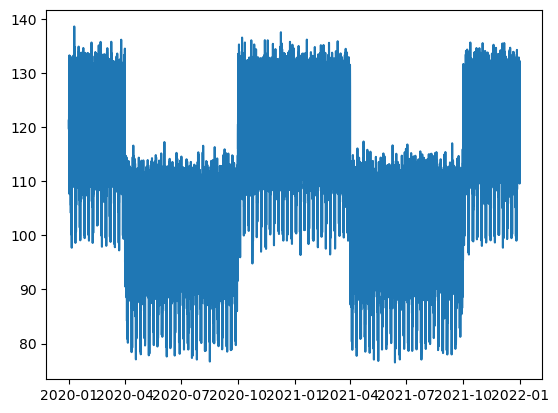

In [35]:
plt.plot(date_range, spot_prices)

In [36]:
# compute the shape 
df = pd.DataFrame(data=spot_prices, index=date_range, columns=['Spot'])
df

,Spot
2020-01-01 00:00:00,121.110687
2020-01-01 01:00:00,119.690832
2020-01-01 02:00:00,121.448276
2020-01-01 03:00:00,123.405598
2020-01-01 04:00:00,119.476417
...,...
2021-12-31 19:00:00,129.120348
2021-12-31 20:00:00,132.005100
2021-12-31 21:00:00,118.503252
2021-12-31 22:00:00,123.916270


In [37]:
base_y = df.resample('Y').mean()
base_y.index = base_y.index.strftime('%Y')

In [38]:
df_spot = df.copy()
df_spot.index = df_spot.index.strftime('%Y')
df_spot

,Spot
2020,121.110687
2020,119.690832
2020,121.448276
2020,123.405598
2020,119.476417
...,...
2021,129.120348
2021,132.005100
2021,118.503252
2021,123.916270


In [47]:
shape = df_spot.divide(base_y, axis='index')
shape_df = pd.DataFrame(data=shape['Spot'].tolist(), index=date_range, columns=['shape'])
shape_df

,shape
2020-01-01 00:00:00,1.112895
2020-01-01 01:00:00,1.099848
2020-01-01 02:00:00,1.115998
2020-01-01 03:00:00,1.133984
2020-01-01 04:00:00,1.097878
...,...
2021-12-31 19:00:00,1.186646
2021-12-31 20:00:00,1.213157
2021-12-31 21:00:00,1.089072
2021-12-31 22:00:00,1.138819


<AxesSubplot: >

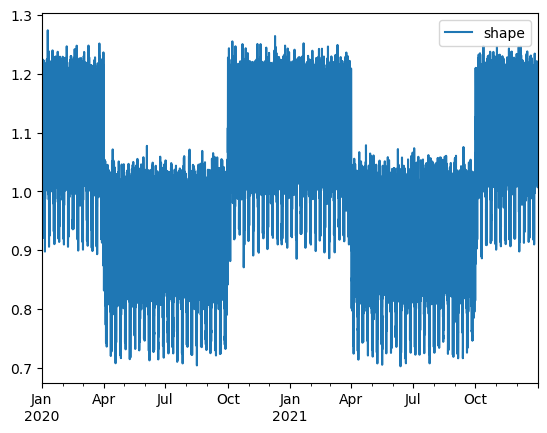

In [48]:
shape_df.plot()

In [49]:
contracts_schedules = {
    'Cal20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2021,1,1), freq='1H'),
    'Cal21_Base': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H'),
    'Q1/20_Base': SimpleSchedule(dt.datetime(2020,1,1), dt.datetime(2020,4,1), freq='1H'),
    'Q2/20_Base': SimpleSchedule(dt.datetime(2020,4,1), dt.datetime(2020,7,1), freq='1H'),
    'Q3/20_Base': SimpleSchedule(dt.datetime(2020,7,1), dt.datetime(2020,10,1), freq='1H'),
    'Cal21_Peak': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H', hours=set(np.arange(8,21))),
    'Cal21_OffPeak': SimpleSchedule(dt.datetime(2021,1,1), dt.datetime(2022,1,1), freq='1H', hours=set(np.arange(0,24))-set(np.arange(8,21)))
}

In [50]:
contracts = {}
for contract_name, schedule in contracts_schedules.items():
    tg = schedule.get_schedule()
    price = df.loc[tg,:].mean()[0]
    contracts[contract_name] = EnergyFutureSpecifications(schedule=schedule, price=price, name=contract_name)

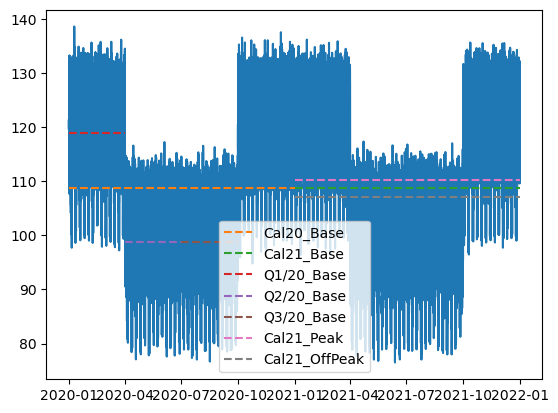

In [51]:

plt.plot(date_range, spot_prices)
ax = plt.gca()
for name, contract in contracts.items():
    y_value = contract.price  # The y-coordinate for the horizontal line
    x_range = contract.schedule.get_schedule()  # List of datetime values
    
    # Extract the minimum and maximum dates from the x_range
    xmin = min(x_range)
    xmax = max(x_range)
    
    # Plot a horizontal line for the contract
    color = next(ax._get_lines.prop_cycler)['color']
    plt.hlines(y=y_value, xmin=xmin, xmax=xmax, linestyle='--', label=name, colors=color)

plt.legend()
plt.show()

In [65]:
PFCShifter(shape=shape_df, contracts=contracts)